# Initial Graph Analysis: *Occupation Probability Calculations*

Prior to conducting a percolation analysis we conduct some initial calculations of the occupation probability. 

Occupation probability is the likelihood or probabilty that a specific node or edge will not be removed or remain *occupied* during a top-down percolation. 

It can be calculaed using any weight. In this notebook we calculate it using *Angle Severity*, *Distance* and *Time*.

In [2]:
# load relevant packages for analysis
import contextily as ctx
import dask.dataframe as dd
import dask_geopandas as dg
import fiona
import geopandas as gpd
import igraph
import math
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.cm import ScalarMappable
from matplotlib.collections import LineCollection
import matplotlib.lines as mlines
import numpy as np
import networkx as nx
import osmnx as ox
import pandas as pd
import pyogrio
import seaborn as sns
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.preprocessing import StandardScaler
from shapely.geometry import Point
from shapely.geometry import LineString, MultiLineString
import shapely.wkt
import statsmodels.api as sm
import sys
from xml import etree

# A. Prepare Data

## 1. Read in Graph created from OS Open Roads data and Plot

In [2]:
# simplified graph
# G = nx.read_graphml("Data/G_simple.graphml')

In [3]:
# read in uk street network data
G = nx.read_graphml("Data/road_network.graphml")

In [4]:
# print sample of nodes & edges
sample_nodes = list(G.nodes(data=True))[0]
print("\nSample nodes:")
for node in sample_nodes:
    print(node)
    
sample_edges = list(G.edges(data=True))[0]
print("\nSample edges:")
for edge in sample_edges:
    print(edge)


Sample nodes:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
{'pos': '(187422.39, 887423.74)', 'form_of_road_node': 'junction', 'geometry': 'POINT (187422.39 887423.74)'}

Sample edges:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
D3B5B123-54B7-467E-8C60-BE2383A3624B
{'length': 179.0, 'road_classification': 'Unknown', 'road_function': 'Restricted Local Access Road', 'form_of_way': 'Single Carriageway', 'primary_route': False, 'trunk_road': False, 'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)'}


#### Plot the Graph

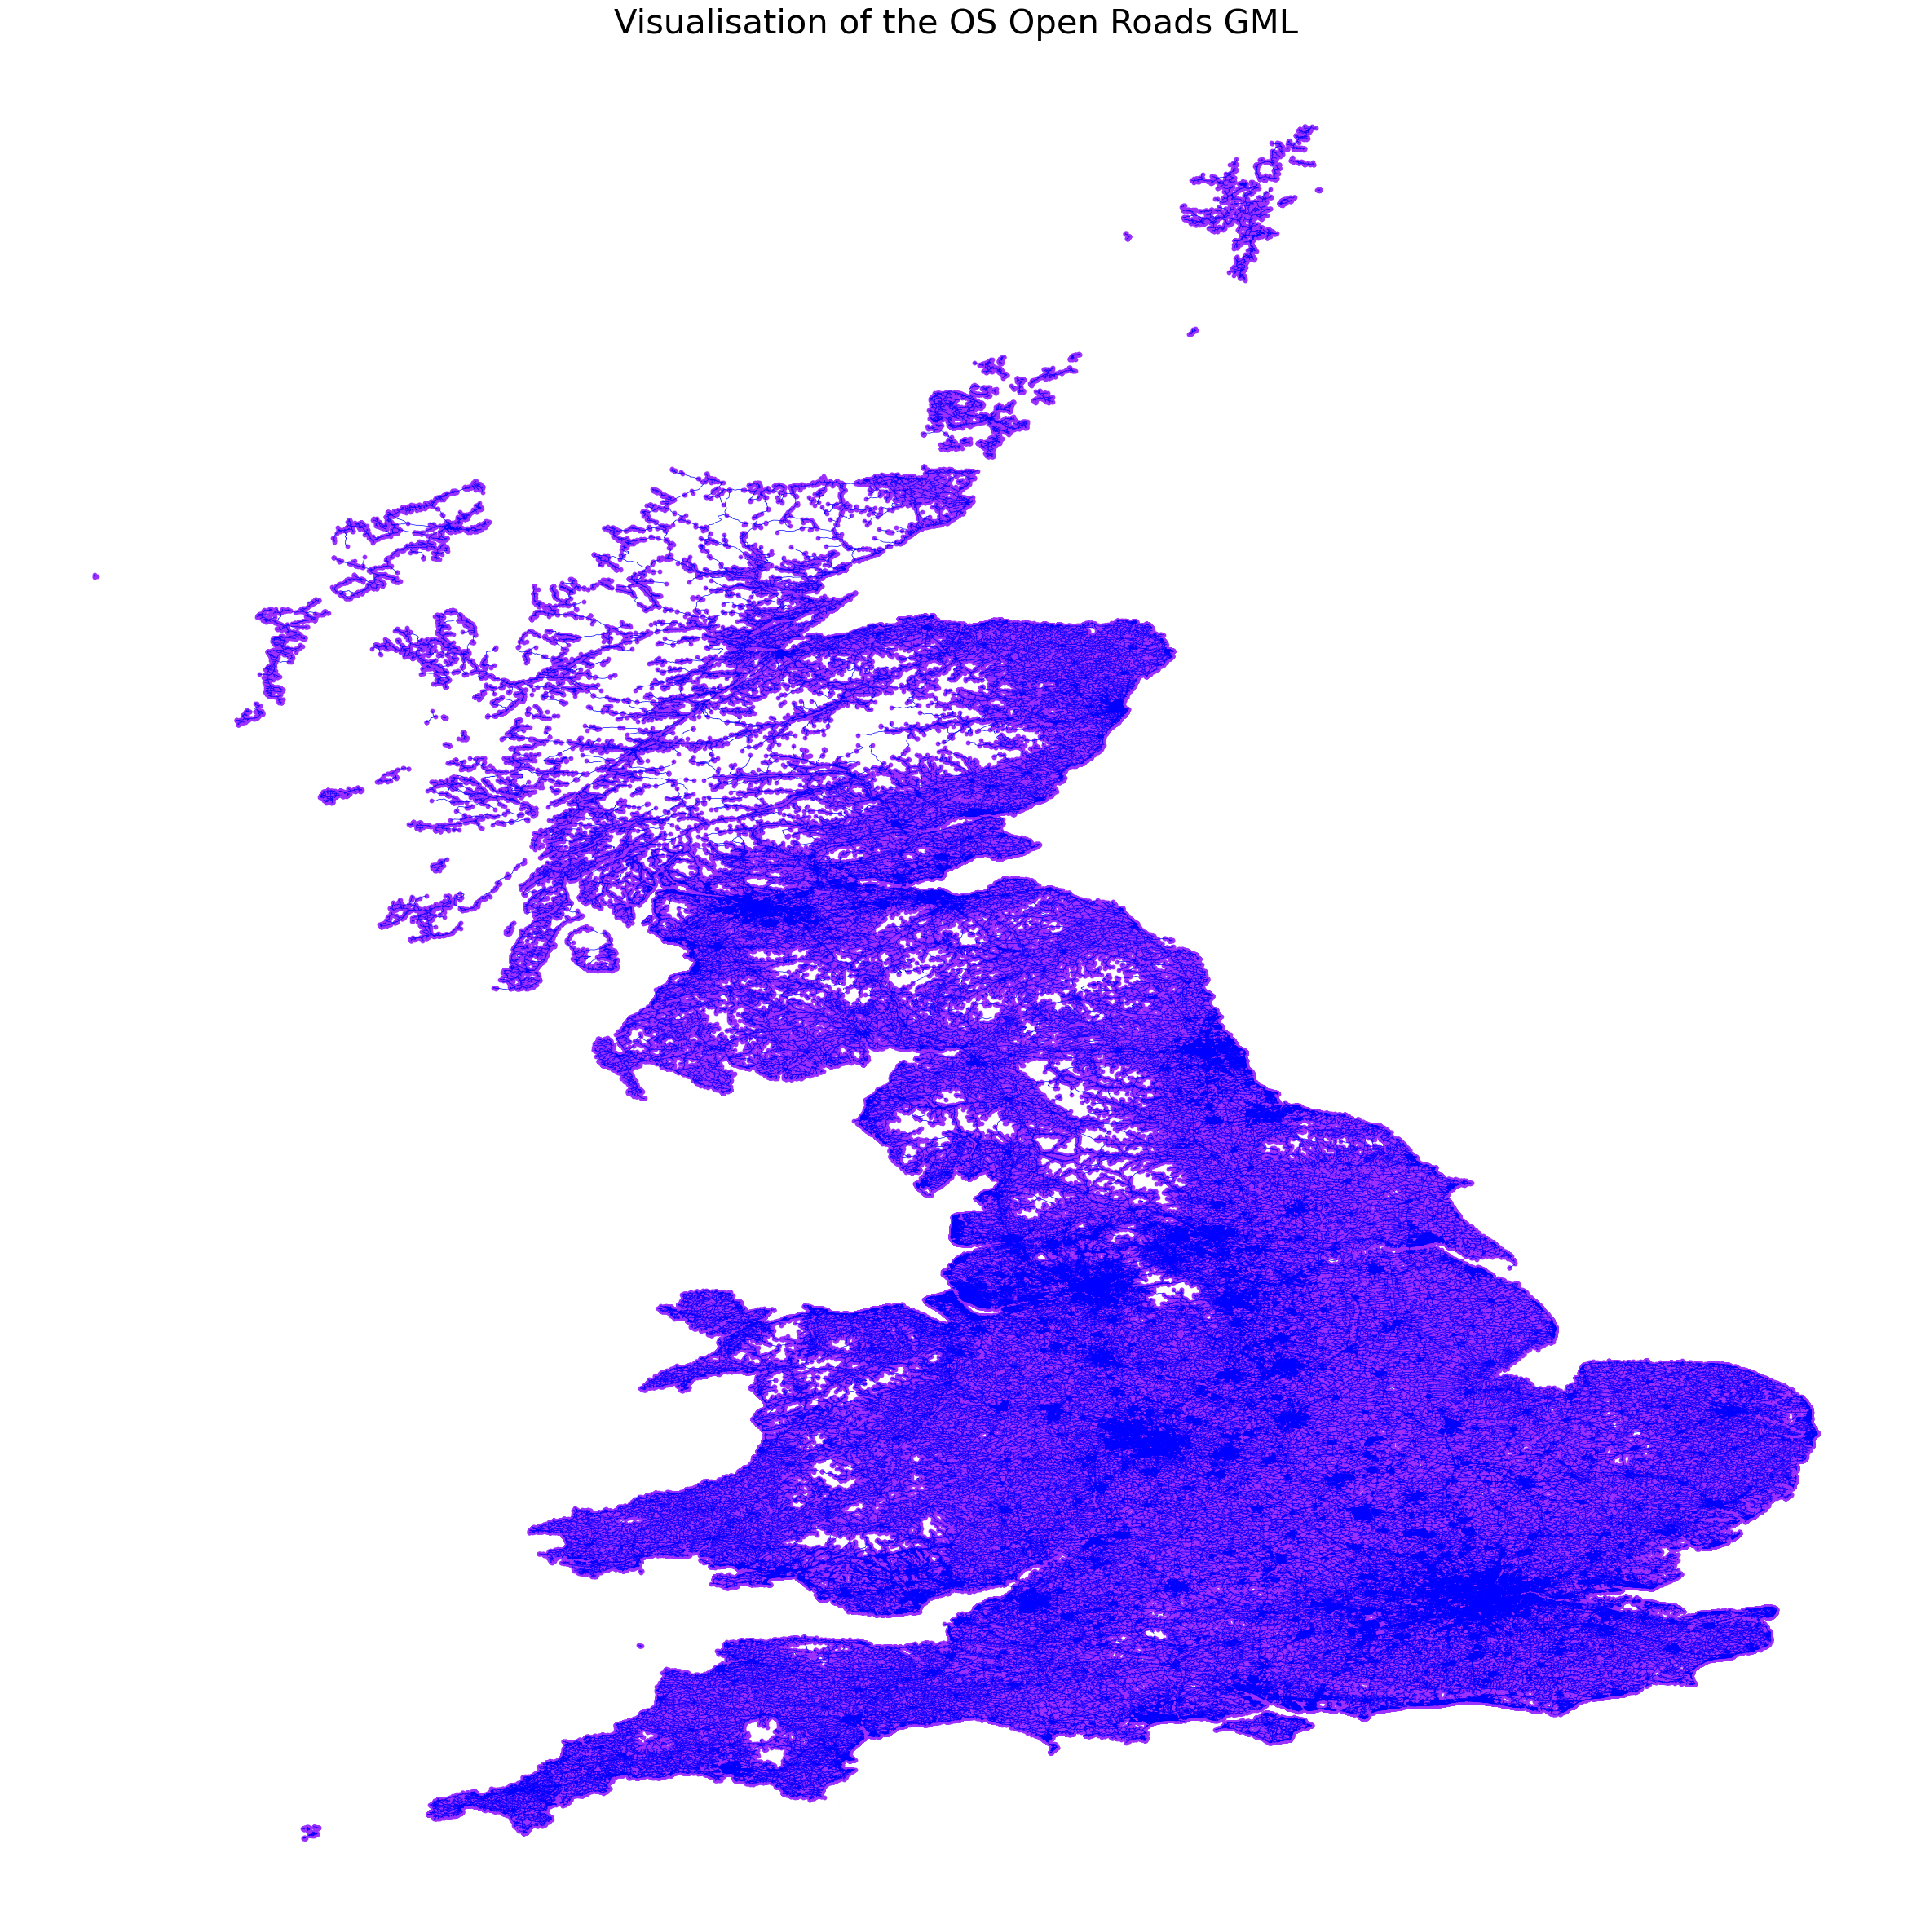

In [5]:
# def func. to convert WKT format to tuples
def parse_linestring(geometry):
    line = shapely.wkt.loads(geometry)
    return list(line.coords)

# get node positions from the 'pos' attribute
pos = {node: tuple(map(float, data['pos'].strip('()').split(','))) for node, data in G.nodes(data=True)}

# get edges with their geometry converted to coordinate lists
lines = [(parse_linestring(data['geometry'])) for u, v, data in G.edges(data=True)]

# create a LineCollection from the list of lines
lc = LineCollection(lines, colors='blue', linewidths=0.5)
fig, ax = plt.subplots(figsize=(20, 30))

# plot nodes
nx.draw_networkx_nodes(G, pos, node_size=10, node_color="#9B30FF", ax=ax)

# add LineCollection to the plot
ax.add_collection(lc)

# title & remove axis
plt.title("Visualisation of the OS Open Roads GML", fontsize=30)
plt.axis("off")
plt.show()

# B. Calculate New *Angle* Attributes and Add to Network

## 2. Calculate Angle for Nodes & Edges
Prior to conducting Percolation Analysis, a copy of *G* is created, *G_percolation*. This ensures the original file is left in its original state.

Furthermore, before executing the percolation analysis we must add attributes to the edges and nodes within the network. Since we will be analysing percolation in regards to Length and the Angular Network we calculate these values and add them to our graph.

This analysis will leverage the existing *'length'* column to conduct a distance based percolation.

In [6]:
# create duplicate
G_percolation = G.copy()

### 2.2 Add black 'angle' attribute to Nodes

In [7]:
# add 'angle' placeholder to nodes
for node in G_percolation.nodes:
    G_percolation.nodes[node]['angle'] = 0

### 2.3 Define function for calculating the angle between road segments

In [8]:
def calculate_angle(p1, p2, p3):
    """
    Calculate the angle (in degrees) formed by the lines p1p2 and p2p3.
    p1, p2, p3 are tuples representing (x, y) coordinates.
    """
    def vector(a, b):
        return (b[0] - a[0], b[1] - a[1])
    
    def dot_product(v1, v2):
        return v1[0] * v2[0] + v1[1] * v2[1]
    
    def magnitude(v):
        return math.sqrt(v[0]**2 + v[1]**2)
    
    v1 = vector(p2, p1)
    v2 = vector(p2, p3)
    
    mag1 = magnitude(v1)
    mag2 = magnitude(v2)
    
    if mag1 == 0 or mag2 == 0:
        return 0  # if vector has zero magnitude, return angle as 0
    
    dot_prod = dot_product(v1, v2)
    cos_angle = dot_prod / (mag1 * mag2)
    
    # to handle floating point errors that might cause cos_angle to be out of [-1, 1]
    cos_angle = min(1, max(-1, cos_angle))
    
    angle_rad = math.acos(cos_angle)
    angle_deg = math.degrees(angle_rad)
    
    return angle_deg

In [9]:
# Extract positions from nodes
pos = {node: tuple(map(float, data['pos'].strip('()').split(', '))) for node, data in G_percolation.nodes(data=True)}

# Calculate angles for nodes with at least two neighbors
for node in G_percolation.nodes:
    neighbors = list(G_percolation.neighbors(node))
    if len(neighbors) >= 2:
        # Calculate angles between the first two neighbors and the node itself
        p2 = pos[node]
        p1 = pos[neighbors[0]]
        p3 = pos[neighbors[1]]
        angle = calculate_angle(p1, p2, p3)
        G_percolation.nodes[node]['angle'] = angle  # Add angle to node attributes
    else:
        G_percolation.nodes[node]['angle'] = 0

print("Angles calculated and added to nodes.")

Angles calculated and added to nodes.


In [12]:
# check new fields were added
# print sample of nodes & edges
sample_nodes = list(G_percolation.nodes(data=True))[0]
print("\nSample nodes:")
for node in sample_nodes:
    print(node)

sample_edges = list(G_percolation.edges(data=True))[0]
print("\nSample edges:")
for edge in sample_edges:
    print(edge)


Sample nodes:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
{'pos': '(187422.39, 887423.74)', 'form_of_road_node': 'junction', 'geometry': 'POINT (187422.39 887423.74)', 'angle': 126.44988586701946}

Sample edges:
CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D
D3B5B123-54B7-467E-8C60-BE2383A3624B
{'length': 179.0, 'road_classification': 'Unknown', 'road_function': 'Restricted Local Access Road', 'form_of_way': 'Single Carriageway', 'primary_route': False, 'trunk_road': False, 'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)'}


In [11]:
nx.write_graphml(G_percolation, "Data/G_percolation.graphml")

# B. Conduct Initial Percolation Analysis: Derive Occupation Probabilities for Node Angle and Edge Length
In percolation theory, the primary variable of interest is often the occupation probability (denoted as 𝑝). 
This is the probability that a given node or edge in the network remains occupied (or active) after a certain fraction of nodes or edges have been removed.

There are three main concepts which are regularly calculated:
1. Occupation Probability ( 𝑝): The fraction of nodes or edges that are retained in the network.
2. Percolation Threshold (𝑝𝑐): The critical occupation probability at which the network transitions from being largely connected to largely disconnected. Below this threshold, the network starts to break into smaller disconnected components.
3. Giant Component: The largest connected component of the network. In percolation analysis, the size of the giant component is tracked as nodes or edges are progressively removed.


Given the focus of this project and its validation of the movement economy, understanding the impact of spatial configuration on land use and movement and exploring the resilience and robustness of urban networks, a top-down approach to percolation is most suitable. This approach allows you to:

There are 3 key reasons for this.

1. Simulate Real-World Scenarios: Mimic how urban networks respond to real-world changes, disruptions and degradations.
2. Identify Critical Thresholds: Find the points at which network connectivity is critically impacted, providing valuable insights into the robustness of the network.
3. Focus on Degradation and Connectivity: Directly study the effects of removing nodes or edges on the network’s overall connectivity and movement patterns, which aligns with the goals of your project.

In [ ]:
# read in uk street network data
G_percolation = nx.read_graphml("Data/G_percolation.graphml")

## 1. Angular Percolation Analysis

In [13]:
# normalise values to a range of [0, 1]
def normalise(value, min_value, max_value):
    return (value - min_value) / (max_value - min_value)

# calc max / min values for 'angle'
max_angle = max(data['angle'] for node, data in G_percolation.nodes(data=True))
min_angle = min(data['angle'] for node, data in G_percolation.nodes(data=True))

# calc occ probs for nodes
for node, data in G_percolation.nodes(data=True):
    angle = data['angle']
    data['occupation_probability'] = normalise(angle, min_angle, max_angle)

# ensure attributes are added correctly
print("Sample node with occupation probability:", list(G_percolation.nodes(data=True))[0])

Sample node with occupation probability: ('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D', {'pos': '(187422.39, 887423.74)', 'form_of_road_node': 'junction', 'geometry': 'POINT (187422.39 887423.74)', 'angle': 126.44988586701946, 'occupation_probability': 0.7024993659278859})


## 2. Distance Based Percolation Analysis

In [14]:
# calc max and min values for 'length'
max_length = max(data['length'] for u, v, data in G_percolation.edges(data=True))
min_length = min(data['length'] for u, v, data in G_percolation.edges(data=True))

# calc occ probs for edges
for u, v, data in G_percolation.edges(data=True):
    length = data['length']
    data['occupation_probability'] = normalise(length, min_length, max_length)

# ensure attributes are added correctly
print("Sample edge with occupation probability:", list(G_percolation.edges(data=True))[0])

Sample edge with occupation probability: ('CC9BEF56-6F33-47ED-AF08-BB8A6C655A1D', 'D3B5B123-54B7-467E-8C60-BE2383A3624B', {'length': 179.0, 'road_classification': 'Unknown', 'road_function': 'Restricted Local Access Road', 'form_of_way': 'Single Carriageway', 'primary_route': False, 'trunk_road': False, 'geometry': 'LINESTRING (187422.39 887423.74, 187436.12 887429.24, 187434.34 887455.56, 187439.76 887465.66, 187472.56 887482.08, 187552.42 887522.05)', 'occupation_probability': 0.00927614779300641})


In [15]:
# save updated graph
# nx.write_graphml(G_percolation, "Data/G_percolation.graphml")

# C. Plot Percolation Probability

In [3]:
G_percolation = nx.read_graphml("Data/G_percolation.graphml")

## Node Occupation Probabilities

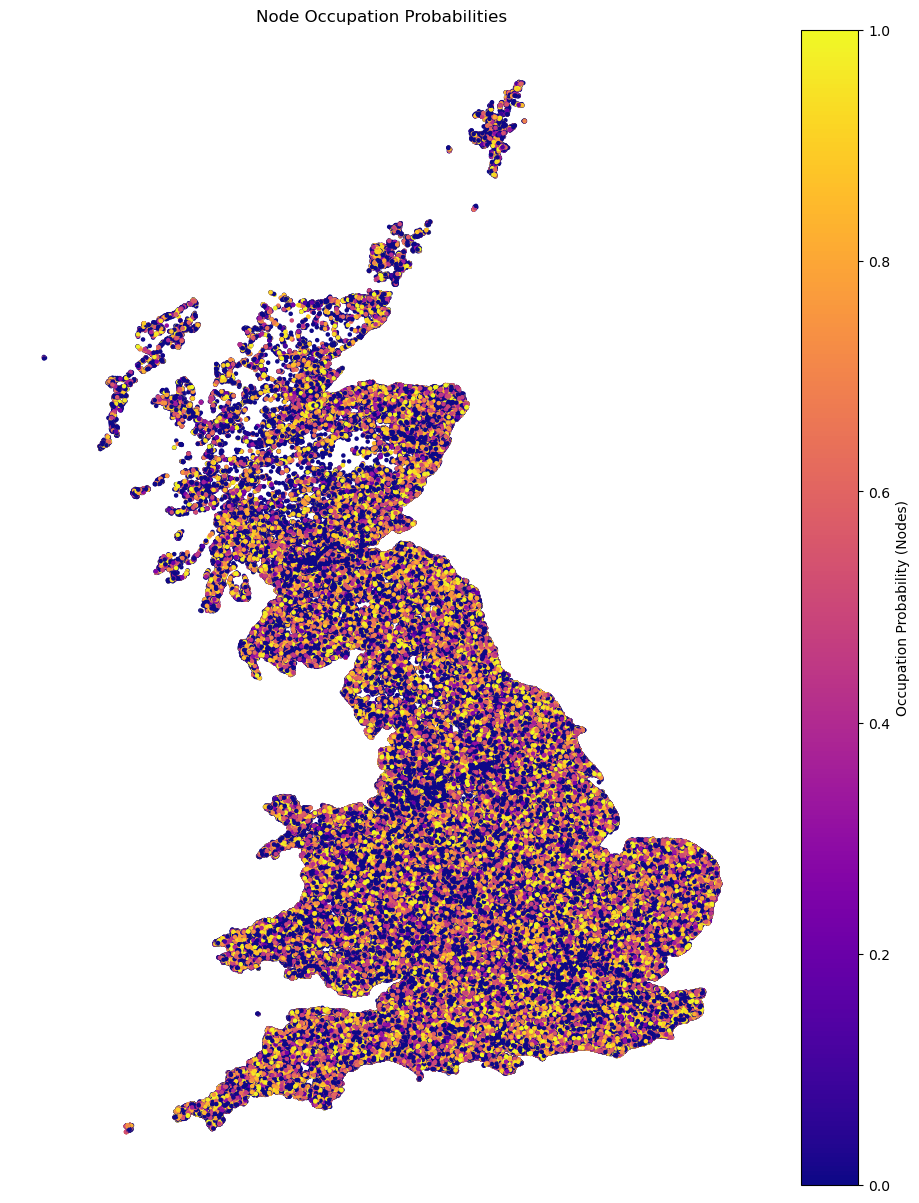

In [20]:
# occupation probabilities for nodes
node_probs = [data['occupation_probability'] for node, data in G_percolation.nodes(data=True)]

# node positions
pos = {node: tuple(map(float, data['pos'].strip('()').split(', '))) for node, data in G_percolation.nodes(data=True)}

# plot node occupation probabilities
plt.figure(figsize=(20, 30))
nodes = nx.draw_networkx_nodes(G_percolation, pos, node_color=node_probs, cmap=plt.cm.plasma, node_size=1)
plt.colorbar(nodes, label='Occupation Probability (Nodes)')
plt.title('Node Occupation Probabilities')
plt.axis('off')
plt.show()a

## Edge Occupation Probabilities

<Figure size 2000x3000 with 0 Axes>

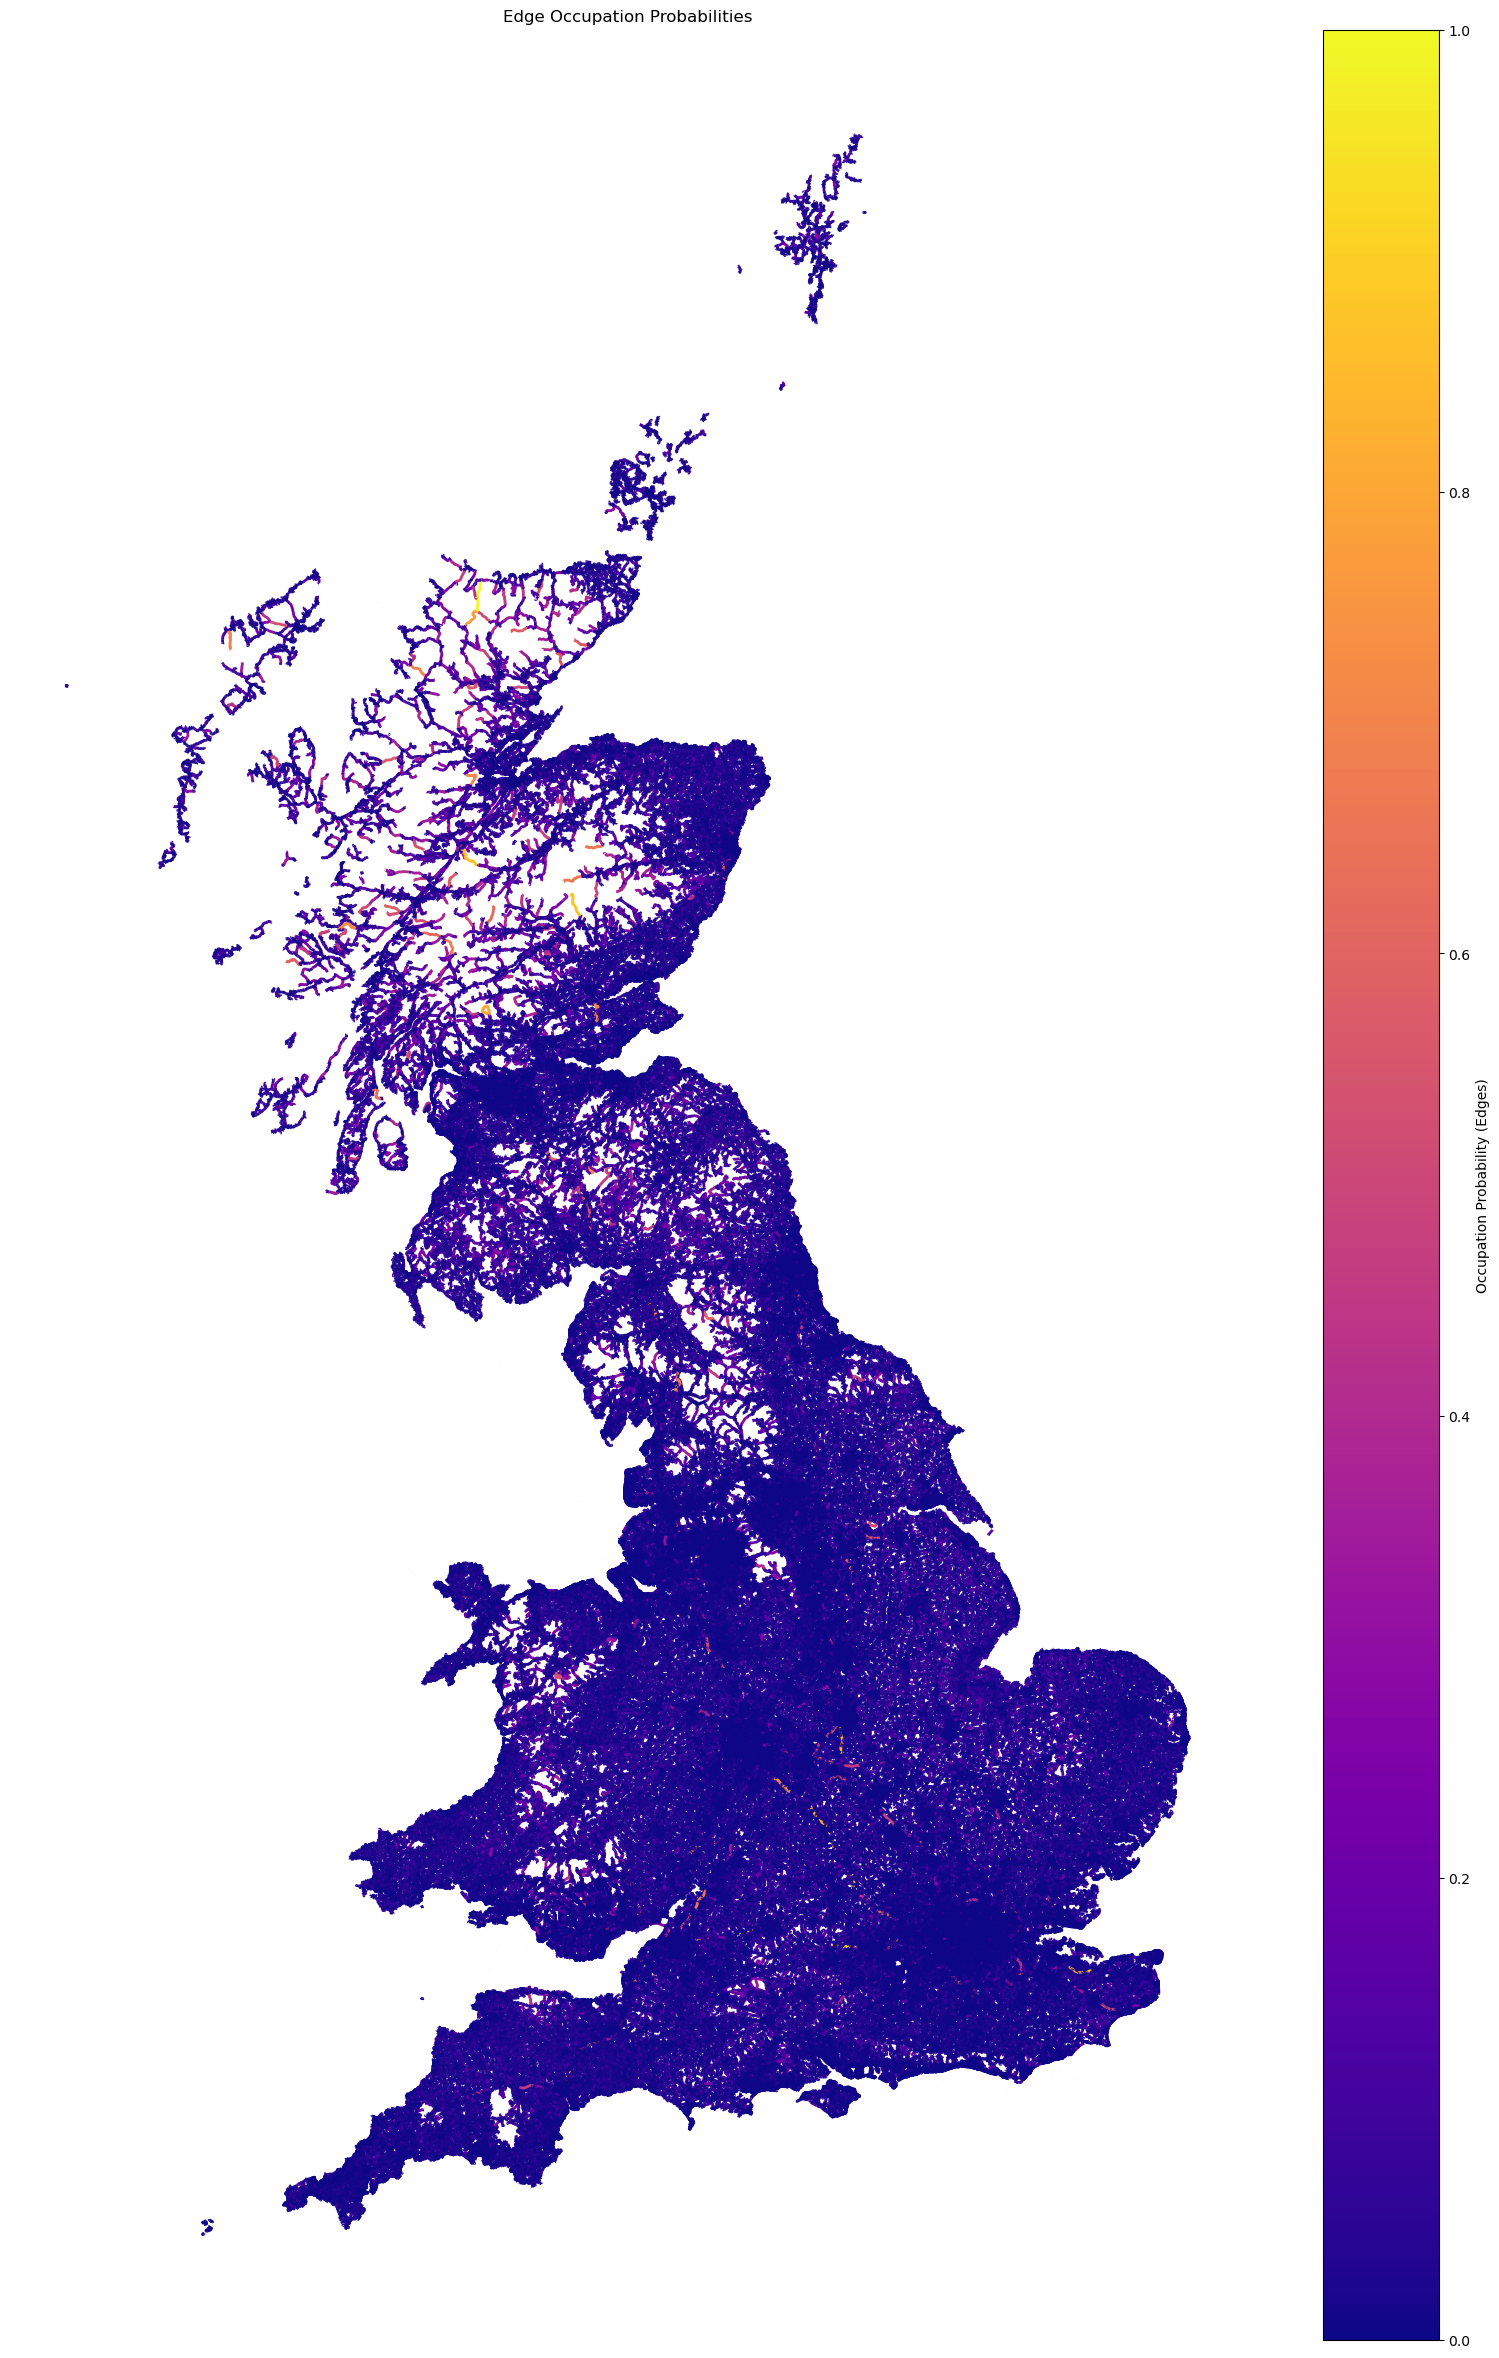

In [4]:
# define function to convert 'LINESTRING' to list of tuples
def parse_linestring(geometry_str):
    return [tuple(map(float, coord.split())) for coord in geometry_str.strip('LINESTRING ()').split(', ')]

# figure
plt.figure(figsize=(20, 30))

# get lines and their colors
lines = []
colors = []

# plot edges based on its geometry
for u, v, data in G_percolation.edges(data=True):
    geometry = data['geometry']
    occupation_prob = data['occupation_probability']

    line = LineString(parse_linestring(geometry))
    x, y = line.xy
    lines.append(list(zip(x, y)))
    colors.append(occupation_prob)

# create LineCollection
lc = LineCollection(lines, cmap='plasma', norm=plt.normalise(vmin=0, vmax=1), linewidths=2)
lc.set_array(colors)

# add LineCollection to the plot
fig, ax = plt.subplots(figsize=(20, 30))
ax.add_collection(lc)
ax.autoscale()
ax.set_aspect('equal')
plt.colorbar(lc, label='Occupation Probability (Edges)')

plt.title('Edge Occupation Probabilities')
plt.axis('off')
plt.show()